# FF Convergence

In [1]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import tensorflow as tf
import random
import pickle as pkl

from qiskit.quantum_info import Operator, Statevector, random_unitary
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from quantum_tools import circuit_to_matrix, partial_trace
from kraus_channels import isomery_to_kraus, KrausMap, kraus_marginalize, DilutedKrausMap
from quantum_channel import ConcatChannel, DilutedChannel, IdentityChannel, ChoiMapStatic
from utils import numberToBase, kron
from spectrum import complex_spacing_ratio, channel_spectrum, Spectrum, mean_spacing, coat_spectrum
from analysis import spectrum_to_angular, spectrum_to_radial, hist_ensamble
from qiskit.circuit.library import iSwapGate, XGate, YGate, HGate, CXGate, RGate, RZGate
from quantum_circuits import integrable_circuit, nonintegrable_circuit, haar_random
from synthetic_data import generate_map_data, generate_spam_data, generate_spam_benchmark
from optimization import ModelQuantumMap, ModelSPAM, Logger, model_saver
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from spam import SPAM, InitialState, POVMwQR as POVM, CorruptionMatrix

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=1)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


## Circuits

In [2]:
def sample_traceout_csr(n, n_anc, reps, circuit_type, L, p, r):
    channel_list = []
    spectra_list = []
    csr_list = []
    d = 2**n

    for _ in tqdm(range(reps)):
        circuit = circuit_type(n+n_anc, L)
        U = Operator(circuit).data

        kraus_chaos = KrausMap(2*d, rank=r)
        kraus_map = DilutedKrausMap(U, c=1-p, kraus_part = kraus_chaos)
        
        kraus_map = kraus_marginalize(kraus_map)
        channel_list.append(kraus_map)
        
        spectrum = channel_spectrum(kraus_map)
        spectra_list.append(spectrum)
        csr = complex_spacing_ratio(spectrum, log=False)
        csr_list.append(csr)

    return  channel_list, spectra_list, csr_list

In [3]:
def fit_spam(inputs, 
             targets,
             num_iter = 3000,
             verbose = False):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = verbose,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets,
              channel, 
              spam_model,
              num_iter = 3000,
              verbose=False):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue(), channel_fidelity_loss], sample_freq=100),
                )
    model.train(inputs = inputs, 
                targets = targets,
                inputs_val = [inputs, None],
                targets_val = [targets, [channel]],
                N=500,
                num_iter = num_iter,
                verbose = verbose,)
    
    return model

## Free Fermion

### Generate Benchmarks

In [4]:
from scipy.optimize import curve_fit

def func1(x, a):
    return a*np.sqrt(x)

def func2(x, a, b):
    return a*x**2 + b

In [5]:
L = 10
CNOTs = 4*L

popt_p = [0.0459]
popt_r = [8.9846e-04, 1.1474e+01]

p = func1(CNOTs, *popt_p)
r = ceil(func2(CNOTs, *popt_r))

print(p, r)

0.29029708920345726 13


In [6]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
n_anc = 1
d = 2**n
reps = 10

channel_FF_list, spectra_FF_list, csr_FF_list = sample_traceout_csr(n, n_anc, reps, integrable_circuit, L, p, r)

pkl.dump([channel_FF_list, spectra_FF_list, csr_FF_list], open("data/FF_DU_synthetic_benchmark.pkl", "wb"))

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
n_anc = 1
d = 2**n
reps = 10

channel_AI_list, spectra_AI_list, csr_AI_list = sample_traceout_csr(n, n_anc, reps, nonintegrable_circuit, L, p, r)

pkl.dump([channel_AI_list, spectra_AI_list, csr_AI_list], open("data/AI_DU_synthetic_benchmark.pkl", "wb"))

  0%|          | 0/10 [00:00<?, ?it/s]

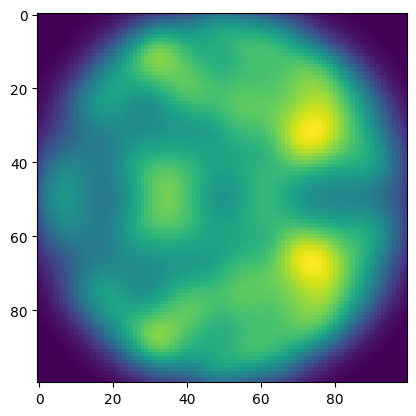

In [8]:
#for csr in csr_FF_list:
#    csr.plot_circle()
#    csr.plot()
#    plt.show()

csr_coat = coat_spectrum(Spectrum(csr_FF_list))
plt.imshow(csr_coat)

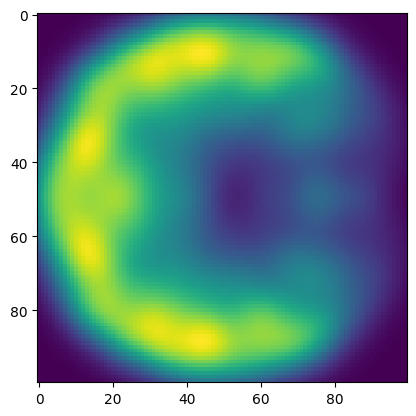

In [9]:
#for csr in csr_FF_list:
#    csr.plot_circle()
#    csr.plot()
#    plt.show()

csr_coat = coat_spectrum(Spectrum(csr_AI_list))
plt.imshow(csr_coat)

### Generate Synthetic Data and Fit

In [10]:
model_list = []

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

for channel in channel_FF_list:
    
    spam_target = generate_spam_benchmark(n=4, c1=0.95, c2=0.95)
    inputs_spam, targets_spam = generate_spam_data(spam_target, shots=12000)
    
    spam_model = fit_spam(inputs_spam,
                        targets_spam,
                        num_iter = 3000,
                        verbose = False)
        

    inputs_map, targets_map = generate_map_data(channel, 
                                                spam_target = spam_target,
                                                N_map=5000-6**n, 
                                                shots = 12000)

    model = fit_model(inputs_map,
                    targets_map,
                    channel,
                    spam_model,
                    num_iter = 3000,
                    verbose = False
                    )

    model_list.append(model)

model_saver(model_list, "models/model_list_FF_noisy_DU.model")


[0.9974823418669839, -0.8615284584559323]
[0.9973530945925462, -0.8612633783474914]
[0.9973211232864607, -0.8618579722844603]
[0.9972599431325333, -0.8619294785686983]
[0.9977393473112272, -0.8648730962506652]
[0.9974176200638335, -0.8603976282052938]
[0.9973636457850806, -0.8605593911881065]
[0.9977505343798914, -0.8629666026855904]
[0.9977716116867476, -0.8613051295764853]
[0.9972406552644747, -0.8616498149359847]


## Chaotic Haar Random

### Generate Benchmarks

In [ ]:
n = 4
d = 2**n

[channel_FF_list, spectra_FF_list, csr_FF_list] =  pkl.load(open("data/AI_DU_synthetic_benchmark.pkl", "rb"))

### Generate Synthetic Data and Fit

In [12]:
model_list = []

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

for channel in tqdm(channel_FF_list):
    
    spam_target = generate_spam_benchmark(n=4, c1=0.95, c2=0.95)
    inputs_spam, targets_spam = generate_spam_data(spam_target, shots=12000)
    
    spam_model = fit_spam(inputs_spam,
                        targets_spam,
                        num_iter = 3000,
                        verbose = False)
        

    inputs_map, targets_map = generate_map_data(channel, 
                                                spam_target = spam_target,
                                                N_map=5000-6**n, 
                                                shots = 12000)

    model = fit_model(inputs_map,
                    targets_map,
                    channel,
                    spam_model,
                    num_iter = 3000,
                    verbose = False
                    )

    model_list.append(model)

model_saver(model_list, "model_list_chaotic_noisy_POVM.model")


  0%|          | 0/10 [00:00<?, ?it/s]

[0.9965744651865197, -0.9879946079271656]
[0.9965611043539115, -0.988970383709137]
[0.9965775501547759, -0.9888708687755593]
[0.9966334601712581, -0.9886510992154597]
[0.9965908086503824, -0.9883169268835605]
[0.996595829316722, -0.9892094808837621]
[0.9965326888918862, -0.9884370116898662]


KeyboardInterrupt: 